In [1]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb


tqdm.pandas()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [3]:
# trazer analise do volume de transação por merchant
# trazer analise dos valores dos mount de merchant num boxplot dividido por empresa, mei e pessoa
# por data, existe um padrao de amount (sazonalidade de pix por cliente?)

# Um cenário legal nessas dados é se houvesse o device que foi realizado a transação
# Assim poderiamos montar um modelo ou até análise para compreender o volume de devices por transações

In [4]:
df = pd.read_parquet('sumup_case.parquet')

In [5]:
df.info(memory_usage='deep', show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1307011 entries, 3883 to 1032114
Data columns (total 98 columns):
 #   Column                                                    Non-Null Count    Dtype         
---  ------                                                    --------------    -----         
 0   event_created_at                                          1307011 non-null  datetime64[ns]
 1   amount                                                    1307011 non-null  int32         
 2   infraction                                                1307011 non-null  int32         
 3   merchant_id                                               1307011 non-null  object        
 4   mc_weeks_signup                                           1286402 non-null  float64       
 5   mc_atm_br_tx_out_count_lifetime                           1301990 non-null  float64       
 6   mc_credit_transfer_out_br_sum_last_30d                    1271522 non-null  float64       
 7   mc_billpay_br_sum_la

In [6]:
df.shape

(1307011, 98)

In [7]:
df.head()

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person
3883,2024-02-02 21:43:57.697,27500,0,DAQQ7TS,322.285714,0.0,411.133179,NaN,0.0,5048.175078,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1830.832071,258.0,0.0,15.0,0.0,NaN,1241.818865,0.0,16.0,930.743908,256.0,NaN,0.0,0.0,0.0,156.272211,0.0,38.872071,0.0,0.0,0,659.021477,NaN,0.0,5,0,0.00,0.186230,1.00,1.00,0.000000,147.157813,1,0.125,0.000,0.000000,3445.753755,191.992590,0,45.048110,0.0,0.000000,0.186230,466.805960,0.000000,44111.647242,0.0,11696.799829,0.000000,87039.229687,3,615,0.000000,0.0,0.000000,0.000000,0.0,1,42927.582445,7,0.186230,60,0,45.048110,0.0,0.0000,1.0,235.00,0.0,0.00,1.0,0.0000,NaN,7.523910e+08,1.404402e+11,4232421,1.548410e+12,6.384952e+07,0,0,1
3884,2024-02-02 20:49:30.476,280550,0,CR4K9VY,66.285714,0.0,35289.128889,170.986536,13.0,334646.251337,0.0,4.0,1.0,0.0,0.0,2000.0,14.034572,173221.941437,578.0,0.0,15.0,3.0,0.0,129469.245694,4.0,897.0,94790.588225,560.0,1958.675642,0.0,0.0,48000.0,17260.028105,0.0,14134.882419,13.0,0.0,7,69591.692416,19.623974,0.0,454,4,773.95,602.917735,3220

In [8]:
# Tratamento dos dados 
# Remoção de nulos e duplicatas

In [9]:
# Não há duplicatatas de merchant sendo mei e pessoa.

In [10]:
df[(df.is_person == 1) & (df.is_mei == 1)]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person


In [11]:
df[(df.is_person == 1) & (df.is_legal_entity == 1)]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person


In [12]:
df[(df.is_mei == 1) & (df.is_legal_entity == 1)]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person


In [13]:
# removendo duplicatas

In [14]:
df.duplicated().sum()

315046

In [15]:
df[df.duplicated()]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person
3883,2024-02-02 21:43:57.697,27500,0,DAQQ7TS,322.285714,0.0,411.133179,NaN,0.0,5048.175078,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1830.832071,258.0,0.0,15.0,0.0,NaN,1241.818865,0.0,16.0,930.743908,256.0,NaN,0.0,0.0,0.0,156.272211,0.0,38.872071,0.0,0.0,0,659.021477,NaN,0.0,5,0,0.00,0.186230,1.00,1.00,0.000000,147.157813,1,0.125,0.000,0.000000,3445.753755,191.992590,0,45.048110,0.0,0.000000,0.186230,466.805960,0.000000,44111.647242,0.0,11696.799829,0.000000,87039.229687,3,615,0.000000,0.0,0.000000,0.000000,0.0,1,42927.582445,7,0.186230,60,0,45.048110,0.000000,0.0000,1.0,235.00,0.0,0.000000,1.0,0.0000,NaN,7.523910e+08,1.404402e+11,4232421,1.548410e+12,6.384952e+07,0,0,1
3884,2024-02-02 20:49:30.476,280550,0,CR4K9VY,66.285714,0.0,35289.128889,170.986536,13.0,334646.251337,0.0,4.0,1.0,0.0,0.0,2000.0,14.034572,173221.941437,578.0,0.0,15.0,3.0,0.0,129469.245694,4.0,897.0,94790.588225,560.0,1958.675642,0.0,0.0,48000.0,17260.028105,0.0,14134.882419,13.0,0.0,7,69591.692416,19.623974,0.0,454,4,773.95,602.91

In [16]:
df[(df.event_created_at == '2024-02-02 21:43:57.697') & (df.merchant_id == 'DAQQ7TS')]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person
3883,2024-02-02 21:43:57.697,27500,0,DAQQ7TS,322.285714,0.0,411.133179,NaN,0.0,5048.175078,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1830.832071,258.0,0.0,15.0,0.0,NaN,1241.818865,0.0,16.0,930.743908,256.0,NaN,0.0,0.0,0.0,156.272211,0.0,38.872071,0.0,0.0,0,659.021477,NaN,0.0,5,0,0.0,0.18623,1.0,1.0,0.0,147.157813,1,0.125,0.0,0.0,3445.753755,191.99259,0,45.04811,0.0,0.0,0.18623,466.80596,0.0,44111.647242,0.0,11696.799829,0.0,87039.229687,3,615,0.0,0.0,0.0,0.0,0.0,1,42927.582445,7,0.18623,60,0,45.04811,0.0,0.0,1.0,235.0,0.0,0.0,1.0,0.0,NaN,7.523910e+08,1.404402e+11,4232421,1.548410e+12,63849516.39,0,0,1
3883,2024-02-02 21:43:57.697,27500,0,DAQQ7TS,322.285714,0.0,411.133179,NaN,0.0,5048.175078,0.0,0.0,0.0,0.0,NaN,0.0,NaN,1830.832071,258.0,0.0,15.0,0.0,NaN,1241.818865,0.0,16.0,930.743908,256.0,NaN,0.0,0.0,0.0,156.272211,0.0,38.872071,0.0,0.0,0,659.021477,NaN,0.0,5,0,0.0,0.18623,1.0,1.0,0.0,147.157813,1,0.125,0.0,0.0,3445.753755,191.99259,0,45.04811,0.0,0.0,0.18623,466.80596,0.0,44111.647242,0.0,11696.79

In [17]:
df[(df.event_created_at == '2024-05-01 09:30:45.536') & (df.merchant_id == 'CEFRA4H')]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person
1032111,2024-05-01 09:30:45.536,10000,0,CEFRA4H,239.285714,0.0,2470.790965,NaN,1.0,40911.308484,0.0,0.0,0.0,0.0,0.0,0.0,NaN,15403.794781,221.0,0.0,5.0,0.0,0.0,9661.178298,0.0,129.0,7122.701527,221.0,100.3352,0.0,0.0,0.0,1170.425304,0.0,928.186122,1.0,0.0,0,4503.593226,NaN,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,7012.757577,935.944323,0,385.55663,0.0,0.0,10.686857,5287.53448,0.0,85263.489642,0.0,1458.402813,0.0,94506.629461,21,4049,0.0,0.0,0.0,0.0,0.0,1,9243.139819,59,10.686857,1748,0,385.55663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,48675332.06,6.902167e+09,379429,5.669885e+10,4425114.62,0,1,0
1032111,2024-05-01 09:30:45.536,10000,0,CEFRA4H,239.285714,0.0,2470.790965,NaN,1.0,40911.308484,0.0,0.0,0.0,0.0,0.0,0.0,NaN,15403.794781,221.0,0.0,5.0,0.0,0.0,9661.178298,0.0,129.0,7122.701527,221.0,100.3352,0.0,0.0,0.0,1170.425304,0.0,928.186122,1.0,0.0,0,4503.593226,NaN,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,7012.757577,935.944323,0,385.55663,0.0,0.0,10.686857,5287.53448,0.0,85263.4896

In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df.duplicated().sum()

0

In [20]:
df.isna().sum()/len(df)

event_created_at                                            0.000000
amount                                                      0.000000
infraction                                                  0.000000
merchant_id                                                 0.000000
mc_weeks_signup                                             0.011343
mc_atm_br_tx_out_count_lifetime                             0.003830
mc_credit_transfer_out_br_sum_last_30d                      0.027480
mc_billpay_br_sum_last_15d                                  0.688513
mc_billpay_br_count_last_1y                                 0.003858
mc_credit_transfer_out_br_sum_last_1y                       0.012533
mc_billpay_br_count_sanction_last_30d                       0.008888
mc_pur_br_count_last_1y                                     0.003858
mc_billpay_br_count_last_15d                                0.015907
mc_atm_br_tx_out_count_last_1y                              0.003858
mc_sanction_count_last_2d         

In [21]:
df.fillna(0, inplace=True)

In [22]:
# Estatística Descritiva

In [23]:
print('total Merchants únicos', df.merchant_id.nunique())
print('total Merchants Pessoas', df[df.is_person == 1].merchant_id.nunique())
print('total MEI', df[df.is_mei == 1].merchant_id.nunique())
print('total Legal Entity',  df[df.is_legal_entity == 1].merchant_id.nunique())

total Merchants únicos 109364
total Merchants Pessoas 89661
total MEI 19561
total Legal Entity 94


In [24]:
print('total transacoes', df.shape[0])
print('total transacoes  Pessoas', df[df.is_person == 1].shape[0])
print('total transacoes MEI', df[df.is_mei == 1].shape[0])
print('total transacoes Legal Entity',  df[df.is_legal_entity == 1].shape[0])

total transacoes 991965
total transacoes  Pessoas 808513
total transacoes MEI 171797
total transacoes Legal Entity 386


In [25]:
merchants_sem_categoria = df.groupby('merchant_id').apply(
    lambda x: (x['is_mei'].sum() == 0) & (x['is_person'].sum() == 0) & (x['is_legal_entity'].sum() == 0)
)
merchants_sem_categoria = merchants_sem_categoria[merchants_sem_categoria]
print('Total de Merchants sem categoria definida:', len(merchants_sem_categoria))

Total de Merchants sem categoria definida: 416


In [26]:
# Transações sem definição de tipo
df[(df.is_mei == 0) & (df.is_person == 0) & (df.is_legal_entity == 0)].shape[0]

11269

In [27]:
df[(df.is_mei == 0) & (df.is_person == 0) & (df.is_legal_entity == 0)]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person
4109,2024-02-23 23:56:40.711,15000,0,DG9PG6R,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0,0.000000,0.000000,0.0,0,0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0,0.000,0.000,0.000000,0.000000,0.000000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,0,0.000000,0.0,0.000000,0.000000,0.0,0,0.000000,0,0.000000,0,0,0.000000,0.00,0.0000,0.0,0.00,0.0,0.0000,0.0,0.0000,0.0,2.963697e+09,5.246415e+11,31276242,5.786655e+12,2.208171e+08,0,0,0
4187,2024-03-06 20:13:27.611,10000,0,CZN6LP7,0.0,10.0,863.333014,0.000000,1.0,3292.718222,0.0,10.0,0.0,10.0,0.0,0.0,0.000000,872.355487,153.0,0.0,53.0,0.0,0.0,792.382980,10.0,60.0,741.951510,152.0,20.073882,0.0,0.0,0.0,596.224750,0.0,184.000179,1.0,0.0,0,637.773180,57.074670,0.0,7,0,0.0,491.788709,2641.00,2896.00,0.000000,545.275472,5,0.000,0.000,0.000000,3370.874738,651.012377

In [28]:
# A base está bem desbalanceada de fraude vs. Não Fraude
# Algoritmos como random forest e decision tree são bons com bases desbalanceados.

In [29]:
df.infraction.value_counts()

infraction
0    986956
1      5009
Name: count, dtype: int64

In [30]:
df.infraction.value_counts(normalize=True)

infraction
0    0.99495
1    0.00505
Name: proportion, dtype: float64

In [31]:
df[(df.is_mei == 0) & (df.is_person == 0) & (df.is_legal_entity == 0)].infraction.value_counts()

infraction
0    11150
1      119
Name: count, dtype: int64

In [32]:
df.describe()

,event_created_at,amount,infraction,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person
count,991965,9.919650e+05,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,9.919650e+05,991965.0,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.0,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.0,991965.0,991965.000000,991965.000000,991965.00000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.0,991965.000000,991965.000000,9.919650e+05,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,9.919650e+05,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,991965.000000,9.919650e+05,9.919650e+05,9.919650e+05,991965.000000,9.919650e+05,9.919650e+05,9.919650e+05,991965.000000,991965.000000,991965.000000,991965.0,9.919650e+05,991965.000000,991965.000000,991965.000000,9.919650e+05,991965

In [33]:
# Feature Selection

In [34]:
df.select_dtypes('object') # Não possuem features categoricas

,merchant_id
3883,DAQQ7TS
3884,CR4K9VY
3885,DSSEHKE
3886,2C2EP9Y
3887,C3NYGCP
...,...
1029544,EURPVGX
1029545,EGQDDV6
1029546,EEUQYYL
1029547,CCXF9DP


In [35]:
# Por ser muitas features iniciais, selecionei inicialmente aquelas que o volume de dados faltantes é inferior a 10%, 
# é uma ótima forma para remover algumas features, mas até essas podem ser boas para o modelo
# Para não ser algo tão subjetivo vou fazer a seleção de features com algum algoritmo
df.loc[:, (df.isna().sum()/len(df)) < 0.1]

,event_created_at,amount,infraction,merchant_id,mc_weeks_signup,mc_atm_br_tx_out_count_lifetime,mc_credit_transfer_out_br_sum_last_30d,mc_billpay_br_sum_last_15d,mc_billpay_br_count_last_1y,mc_credit_transfer_out_br_sum_last_1y,mc_billpay_br_count_sanction_last_30d,mc_pur_br_count_last_1y,mc_billpay_br_count_last_15d,mc_atm_br_tx_out_count_last_1y,mc_sanction_count_last_2d,mc_credit_transfer_in_rounded_amounts_br_sum_last_30d,mc_pur_br_sum_last_15d,mc_credit_transfer_in_br_sum_last_180d,mc_credit_transfer_out_br_count_lifetime,mc_credit_transfer_out_br_count_sanction_last_30d,mc_credit_transfer_out_br_count_last_15d,mc_pur_br_count_last_15d,mc_pep_count_last_2d,mc_credit_transfer_in_br_sum_last_120d,mc_pur_br_count_lifetime,mc_credit_transfer_in_br_count_last_30d,mc_credit_transfer_in_br_sum_last_90d,mc_credit_transfer_out_br_count_last_1y,mc_billpay_br_sum_last_1y,mc_billpay_br_count_pep_br_last_30d,mc_credit_transfer_in_br_count_pep_br_last_30d,mc_credit_transfer_out_rounded_amounts_br_sum_last_30d,mc_credit_transfer_out_br_sum_last_15d,mc_credit_transfer_in_br_count_sanction_last_30d,mc_credit_transfer_in_br_sum_last_15d,mc_billpay_br_count_lifetime,mc_atm_br_tx_out_count_last_15d,mc_credit_transfer_out_rounded_amounts_br_count_last_30d,mc_credit_transfer_in_br_sum_last_60d,mc_pur_br_sum_last_1y,mc_credit_transfer_out_br_count_pep_br_last_30d,mc_chip_tx_succ_count_30d,mc_chip_tx_decl_ext_count_7d,mc_chip_tx_amount_local_decl_ext_sum_15d,mc_chip_tx_amount_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_7d,mc_chip_tx_amount_local_succ_sum_15d,mc_chip_tx_amount_decl_ext_sum_30d,mc_chip_tx_amount_succ_sum_30d,mc_chip_tx_succ_count_7d,decline_ext_rate_30d,mc_tx_cp_mean_decl_ext_last_31d_mw,mc_tx_amount_sum_last_60m,mc_tx_amount_decl_ext_sum_lifetime,mc_tx_amount_succ_sum_last_30d,mc_tx_succ_count_last_24h,mc_tx_amount_succ_sum_last_14d,mc_tx_amount_fail_sum_last_60m,mc_tx_amount_succ_sum_last_60m,mc_tx_amount_succ_sum_last_2d,mc_tx_amount_succ_sum_last_90d,mc_tx_amount_fail_sum_last_14d,mc_tx_amount_succ_sum_lifetime,mc_tx_amount_pend_sum_last_2d,mc_tx_amount_decl_int_sum_lifetime,mc_tx_amount_sum_last_24h,mc_tx_amount_sum_lifetime,mc_tx_succ_count_last_14d,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_last_24h,mc_tx_amount_pend_sum_last_14d,mc_tx_amount_decl_ext_sum_last_14d,mc_tx_amount_decl_ext_sum_last_24h,mc_tx_amount_decl_ext_sum_last_60m,mc_tx_succ_count_last_2d,mc_tx_amount_fail_sum_lifetime,mc_tx_succ_count_last_30d,mc_tx_amount_sum_last_2d,mc_tx_succ_count_last_365d,mc_tx_succ_count_last_60m,mc_tx_amount_sum_last_14d,mc_tx_cp_sum_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_decl_ext_last_30d,mc_tx_count_decl_ext_last_30d,mc_tx_cp_sum_decl_ext_last_30d,mc_tx_cp_count_decl_ext_last_24h,mc_tx_cp_dbt_sum_sq_fail_last_24h,mc_tx_cp_count_decl_ext_last_30d,mc_tx_cp_dbt_sum_sq_fail_last_14d,mc_merchants_ip_count_dist_shared_last_15d,mcc_sum_succ_1y,mcc_sum_sq_succ_30d,mcc_count_succ_1y,mcc_sum_sq_succ_1y,mcc_sum_succ_30d,is_legal_entity,is_mei,is_person
3883,2024-02-02 21:43:57.697,27500,0,DAQQ7TS,322.285714,0.0,411.133179,0.000000,0.0,5048.175078,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1830.832071,258.0,0.0,15.0,0.0,0.0,1241.818865,0.0,16.0,930.743908,256.0,0.000000,0.0,0.0,0.0,156.272211,0.0,38.872071,0.0,0.0,0,659.021477,0.000000,0.0,5,0,0.00,0.186230,1.00,1.00,0.000000,147.157813,1,0.125,0.000,0.000000,3445.753755,191.992590,0,45.048110,0.0,0.000000,0.186230,466.805960,0.000000,44111.647242,0.0,11696.799829,0.000000,87039.229687,3,615,0.000000,0.0,0.000000,0.000000,0.0,1,42927.582445,7,0.186230,60,0,45.048110,0.00,0.0000,1.0,235.00,0.0,0.00,1.0,0.0000,0.0,7.523910e+08,1.404402e+11,4232421,1.548410e+12,6.384952e+07,0,0,1
3884,2024-02-02 20:49:30.476,280550,0,CR4K9VY,66.285714,0.0,35289.128889,170.986536,13.0,334646.251337,0.0,4.0,1.0,0.0,0.0,2000.0,14.034572,173221.941437,578.0,0.0,15.0,3.0,0.0,129469.245694,4.0,897.0,94790.588225,560.0,1958.675642,0.0,0.0,48000.0,17260.028105,0.0,14134.882419,13.0,0.0,7,69591.692416,19.623974,0.0,454,4,7

In [36]:
X = df.drop(columns=['infraction', 'event_created_at', 'merchant_id'])
y = df['infraction']

In [37]:
df.to_parquet('df_cleaned.parquet')

In [38]:
# feature_selection = SelectKBest(score_func=f_classif, k=30) # com random Forest ficou melhor pq ele avalia como uma feature interage com outra, o KBest acaba avaliando isoladamente, 
# X_features = feature_selection.fit_transform(X, y)

In [39]:
# SMOTE (Synthetic Minority Oversampling Technique)
# https://medium.com/@balemar/t%C3%A9cnicas-para-dados-desbalanceados-smote-e-adasyn-f891f9c46c6e
# https://learn.microsoft.com/pt-br/azure/machine-learning/component-reference/smote?view=azureml-api-2

In [40]:
# qtd % de treino e teste e pq?

In [41]:
# - 70% para treino (X_train, y_train)
# - 15% para validação (X_val, y_val)
# - 15% para teste (X_test, y_test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [42]:
smote = SMOTE(random_state=42)
X_train_with_smote, y_train_with_smote = smote.fit_resample(X_train, y_train)

In [43]:
# Normalização

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_smote)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Seleção de features com RandomForest
feature_selection = RandomForestClassifier(
        random_state=42, 
        n_estimators=100,
        max_depth=10,
        min_samples_split=5
)
feature_selection.fit(X_train_scaled, y_train_with_smote)

RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [46]:
df[df.merchant_id == 'DAQQ7TS'].shape

(10, 98)

In [47]:
df[['merchant_id', 'mc_tx_succ_count_lifetime', 'mc_tx_amount_succ_sum_lifetime', 'mc_tx_succ_count_last_365d']]

,merchant_id,mc_tx_succ_count_lifetime,mc_tx_amount_succ_sum_lifetime,mc_tx_succ_count_last_365d
3883,DAQQ7TS,615,44111.647242,60
3884,CR4K9VY,25889,369836.222716,22076
3885,DSSEHKE,263,23521.903089,48
3886,2C2EP9Y,3677,27514.017369,3677
3887,C3NYGCP,102,5296.657546,102
...,...,...,...,...
1029544,EURPVGX,5152,110692.213150,2594
1029545,EGQDDV6,212,5426.428990,0
1029546,EEUQYYL,28479,167962.949327,6706
1029547,CCXF9DP,707,10835.750500,707


In [48]:
rf_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_selection.feature_importances_})
rf_feature_importance["Importance (%)"] = rf_feature_importance["Importance"].apply(lambda x: round(x * 100, 2))
rf_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
rf_feature_importance

,Feature,Importance,Importance (%)
65,mc_tx_succ_count_lifetime,1.505285e-01,15.05
59,mc_tx_amount_succ_sum_lifetime,6.955948e-02,6.96
75,mc_tx_succ_count_last_365d,6.851388e-02,6.85
63,mc_tx_amount_sum_lifetime,6.721871e-02,6.72
0,amount,5.421674e-02,5.42
38,mc_chip_tx_succ_count_30d,4.742302e-02,4.74
45,mc_chip_tx_amount_succ_sum_30d,4.652816e-02,4.65
43,mc_chip_tx_amount_local_succ_sum_15d,4.053178e-02,4.05
1,mc_weeks_signup,4.009966e-02,4.01
57,mc_tx_amount_succ_sum_last_90d,3.048372e-02,3.05


In [49]:
rf_feature_importance.to_csv('feature_importance.csv')

In [50]:
# decide automaticamente quais features manter com base em um limiar de importância.
sfm = SelectFromModel(feature_selection, threshold='mean')
X_train_selected = sfm.transform(X_train_scaled)
X_val_selected = sfm.transform(X_val_scaled)
X_test_selected = sfm.transform(X_test_scaled)

In [51]:
selected_importances = rf_feature_importance[sfm.get_support()]

In [52]:
selected_importances

,Feature,Importance,Importance (%)
65,mc_tx_succ_count_lifetime,0.150528,15.05
59,mc_tx_amount_succ_sum_lifetime,0.069559,6.96
38,mc_chip_tx_succ_count_30d,0.047423,4.74
50,mc_tx_amount_decl_ext_sum_lifetime,0.016052,1.61
71,mc_tx_succ_count_last_2d,0.009473,0.95
87,mcc_sum_succ_1y,0.008804,0.88
88,mcc_sum_sq_succ_30d,0.004336,0.43
21,mc_pur_br_count_lifetime,0.004223,0.42
64,mc_tx_succ_count_last_14d,0.003753,0.38
8,mc_pur_br_count_last_1y,0.003379,0.34


In [ ]:
selected_importances.

In [53]:
# Benchmark para selecionar melhores parametros (tunning) e modelo baseado em arvore que se comporta melhor para desbalanceio de dados 
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

param_grid = {
    'RandomForest': {
        'model__n_estimators': [100],
        'model__max_depth': [10, None],
        'model__min_samples_split': [2, 5]
    },
    'XGBoost': {
        'model__n_estimators': [100],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    }
}
results = []

In [54]:
for model_name, model in tqdm(models.items(), desc="Treinando modelos"):
    print(model_name)
    pipeline = Pipeline([
        ('model', model)
    ])
    
    grid_search = GridSearchCV(
        pipeline, 
        param_grid[model_name], 
        cv=3,
        n_jobs=-1, 
        scoring='roc_auc'
    )
    
    grid_search.fit(X_train_selected, y_train_with_smote)
    
    y_train_pred = grid_search.predict_proba(X_train_selected)[:, 1]
    y_val_pred = grid_search.predict_proba(X_val_selected)[:, 1]
    y_test_pred = grid_search.predict_proba(X_test_selected)[:, 1]
    
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    
    train_auc = roc_auc_score(y_train_with_smote, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    classification_metrics = classification_report(y_test, y_test_pred_class, output_dict=True)
    
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'AUC Train': train_auc,
        'AUC Val': val_auc,
        'AUC Test': test_auc,
        'Precision': classification_metrics['1']['precision'],
        'Recall': classification_metrics['1']['recall'],
        'F1-Score': classification_metrics['1']['f1-score']
    })

Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]

RandomForest
XGBoost


In [55]:
benchmark_df = pd.DataFrame(results)

In [56]:
benchmark_df

,Model,Best Params,AUC Train,AUC Val,AUC Test,Precision,Recall,F1-Score
0,RandomForest,"{'model__max_depth': None, 'model__min_samples...",0.999993,0.968636,0.969415,0.302417,0.716378,0.425296
1,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept...",0.991889,0.962829,0.969612,0.119177,0.902796,0.210559


In [57]:
best_model_name = benchmark_df.loc[benchmark_df['AUC Test'].idxmax()]['Model']
best_model_params = benchmark_df.loc[benchmark_df['AUC Test'].idxmax()]['Best Params']

In [58]:
best_model_params

{'model__learning_rate': 0.1,
 'model__max_depth': 5,
 'model__n_estimators': 100}

In [59]:
best_model = models[best_model_name]

In [60]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [61]:
best_model_params.keys()

dict_keys(['model__learning_rate', 'model__max_depth', 'model__n_estimators'])

In [62]:
# Modelo Final V0

In [63]:
final_model = Pipeline([
    ('model', best_model.set_params(**{key.replace('model__', ''): value for key, value in best_model_params.items()}))
])
final_model.fit(X_train_selected, y_train_with_smote)

Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [64]:
y_train_pred = final_model.predict_proba(X_train_selected)[:, 1]
y_val_pred = final_model.predict_proba(X_val_selected)[:, 1]
y_test_pred = final_model.predict_proba(X_test_selected)[:, 1]

In [89]:
# 
y_test_pred_class = (y_test_pred >= 0.6).astype(int)

Metrics:
AUC Train: 0.9918887040981008
AUC Val: 0.9628288390118397
AUC Test: 0.9696123918390261
Precision: 0.1400470387000214
Recall: 0.8721704394141145
F1-Score: 0.24134119380987473


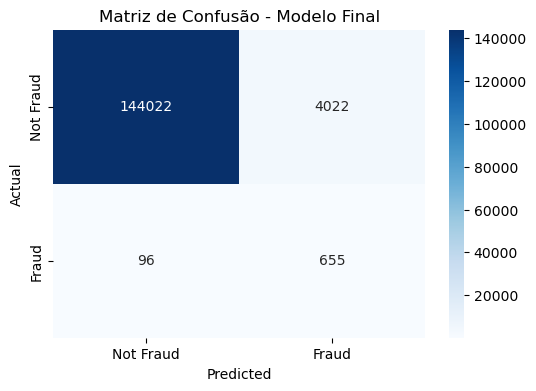

In [90]:

# AUC
train_auc = roc_auc_score(y_train_with_smote, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

# Relatório de classificação
classification_metrics = classification_report(y_test, y_test_pred_class, output_dict=True)

print("Metrics:")
print(f"AUC Train: {train_auc}")
print(f"AUC Val: {val_auc}")
print(f"AUC Test: {test_auc}")
print(f"Precision: {classification_metrics['1']['precision']}")
print(f"Recall: {classification_metrics['1']['recall']:}")
print(f"F1-Score: {classification_metrics['1']['f1-score']:}")

cm = confusion_matrix(y_test, y_test_pred_class)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Matriz de Confusão - Modelo Final")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [67]:
# Recall: para um banco, é pior não detectar uma fraude (e sofrer prejuízo) do que marcar algo como suspeito de fraude/fraudador e verificar depois
    # prioriza identificar todas as fraudes possíveis, mesmo que isso signifique cometer mais falsos positivos, os quais podem ser corrigidos.

# Minha conclusão:
# Quando o modelo erra ao classificar uma transação legítima como fraude (falso positivo), criamos um inconveniente para o cliente. 
# Ele pode ter seu cartão bloqueado durante uma compra importante ou precisar responder perguntas de verificação. 
# uma fraude real que passa despercebida pelo modelo (falso negativo). O prejuízo pode vir. Não é apenas o valor financeiro em jogo, mas também a confiança do cliente na instituição. 
# Esse dilema é um desafio constante para as instituições financeiras e deve ser analisado com base no entendimento do negócio.
# Em minha visão, se perguntarmos aos clientes de um banco, a maioria provavelmente preferiria nunca ser vítima de uma transação fraudulenta, 
# mesmo que isso implique, ocasionalmente, ter uma ou outra transação bloqueada ou precisar passar por uma verificação de segurança adicional.
# Com essa premissa em mente, o objetivo é desenvolver um modelo que priorize um bom recall, buscando identificar a maioria das fraudes, sem comprometer excessivamente a precisão.

#True Negatives (144022): O modelo classificou corretamente 144022 transações não fraudulentas.
#False Positives (4022): O modelo marcou erroneamente 4022 transações legítimas como fraudulentas.
    # Embora relativamente baixos, os falsos positivos (4022) podem gerar problemas ao bloquear transações legítimas, impactando a experiência do cliente.
#False Negatives (276): O modelo não conseguiu identificar 96 fraudes reais.
#True Positives (655): O modelo identificou corretamente 655 fraudes.

In [68]:
#Alto AUC indica que ele tá diferenciando pelo menos bem fraude e não fraud
# A performance consistente nos conjuntos de validação e teste indica boa generalização.

In [69]:
cm

array([[144022,   4022],
       [    96,    655]])

In [70]:
# Próximos passos

# Ajustar o threshold de decisão para balancear precisão e recall conforme as necessidades do negócio.
# Coleta de mais amostras de fraudes para balancear melhor a base de treino

In [71]:
# Pickle

In [72]:
with open('final_model_pix.pkl', 'wb') as f:
    pickle.dump(final_model, f)
    print('Salvo')

Salvo


In [73]:
with open('final_model_pix.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [74]:
X_train_selected

array([[-0.16945639,  2.18659675, -0.16983337, ..., -0.004873  ,
        -0.23062681, -0.23979374],
       [-0.24149514,  0.17179998,  0.3260395 , ..., -0.00686368,
        -0.12577697, -0.0086788 ],
       [-0.23691085, -0.73985393,  0.25165857, ..., -0.00792792,
         0.8006831 ,  0.23225981],
       ...,
       [-0.19681147,  0.37933704, -0.26900794, ..., -0.00805028,
        -0.23062681, -0.25246112],
       [ 0.33415665, -0.85363722, -0.26900794, ..., -0.00805947,
        -0.23062681, -0.25246112],
       [-0.1225297 , -0.85918763, -0.26900794, ..., -0.00805947,
        -0.23062681, -0.25246112]])

In [75]:
random_index = np.random.choice(X_train_selected.shape[0], size=5, replace=False)
random_data = X_train_selected[random_index]
y_pred = loaded_model.predict_proba(random_data)[:, 1]

y_pred_class = (y_pred >= 0.8).astype(int)

print("Previsões para dados\:")
print(f"Probabilidades: {y_pred}")
print(f"Classes previstas: {y_pred_class}")

Previsões para dados\:
Probabilidades: [0.00941878 0.9759169  0.20228866 0.99543    0.00323979]
Classes previstas: [0 1 0 1 0]
